# CS105 Final Project: Amazon Magazine Recommender System

## Project Proposal

We want to create an Amazon Item Recommender System that uses collaborative filtering. To start off, we would choose a random user from the reviews dataset and try to find its neighbors (other closest related users) using the k-NN algorithm.

Using collaborative filtering: given a user, find other similar users whose ratings strongly correlate with the current user

Goal: Starting with one initial user, find similar users (neighbors) who have about the same ratings on items. Then, recommend items to the initial user that they have not reviewed/purchased based on the similar users’ other reviews.

## Data Collection and Data Cleaning

Reading in and cleaning the data from http://deepyeti.ucsd.edu/jianmo/amazon/index.html

Cleaning needed to only include specific columns that are needed for EDA and collaborative filtering, further cleaning is done specific to each EDA instance and the collaborative filtering (ie. dropping unusable tuples like NaN or nonsense values, assimilating text data to each other, formatting, removing commas from integers to work with, etc).

In [3]:
import pandas as pd
df_magsubs = pd.read_json('Magazine_Subscriptions.json', lines=True)
df_metamagsubs = pd.read_json('meta_Magazine_Subscriptions.json', lines=True)

df_magsubs.to_csv()
df_magsubs
df_magsubs = df_magsubs[["overall", "vote", "verified", "reviewerID", "asin", "reviewerName", "reviewText", "summary","image"]]
df_magsubs.dropna(subset=["overall", "vote", "verified", "reviewerID", "asin", "reviewerName", "reviewText", "summary"], inplace=True)
df_magsubs.reset_index()
df_magsubs

df_magsubs['vote'] = df_magsubs['vote'].str.replace('[^\w\s]','',regex=True)
df_magsubs['vote'] = pd.to_numeric(df_magsubs['vote'])

df_magsubs['image'] = pd.notna(df_magsubs['image'])

## EDA

### Magazine Genres

It is important in any situation to know what kind of data is being worked on. There were a large variety of magazines Amazon sold at the time of this data collection, and the most abundant magazine genres are listed below. No one specific genre dominates the distribution of magazine types, but the most prevelant magazines available are professional and educational journals.

In [4]:
df_categories = df_metamagsubs.category
#series_categories.dropna()
df_categories.str.split(pat=",")
df_categories.apply(pd.Series).stack()
df_categories = df_categories.explode('Category')
df_categories = df_categories.to_frame()
df_categories = df_categories[df_categories.category != "Magazine Subscriptions"]
df_categories = df_categories.dropna()
df_categories = df_categories.replace("amp;", "", regex=True)
df_CatCount = df_categories.value_counts().to_frame('amount')
df_CatCount.reset_index(inplace=True)
other = df_CatCount.loc[25:].amount.sum()  
df_CatCount = df_CatCount.loc[:25] 
df_CatCount.loc[len(df_CatCount.index)] = ['Other', other]
df_CatCount

,category,amount
0,Professional & Educational Journals,865
1,Professional & Trade,856
2,"Sports, Recreation & Outdoors",355
3,Sports & Leisure,344
4,"Travel, City & Regional",281
5,Humanities & Social Sciences,279
6,United States,244
7,Arts,195
8,Fashion & Style,148
9,Home & Garden,135


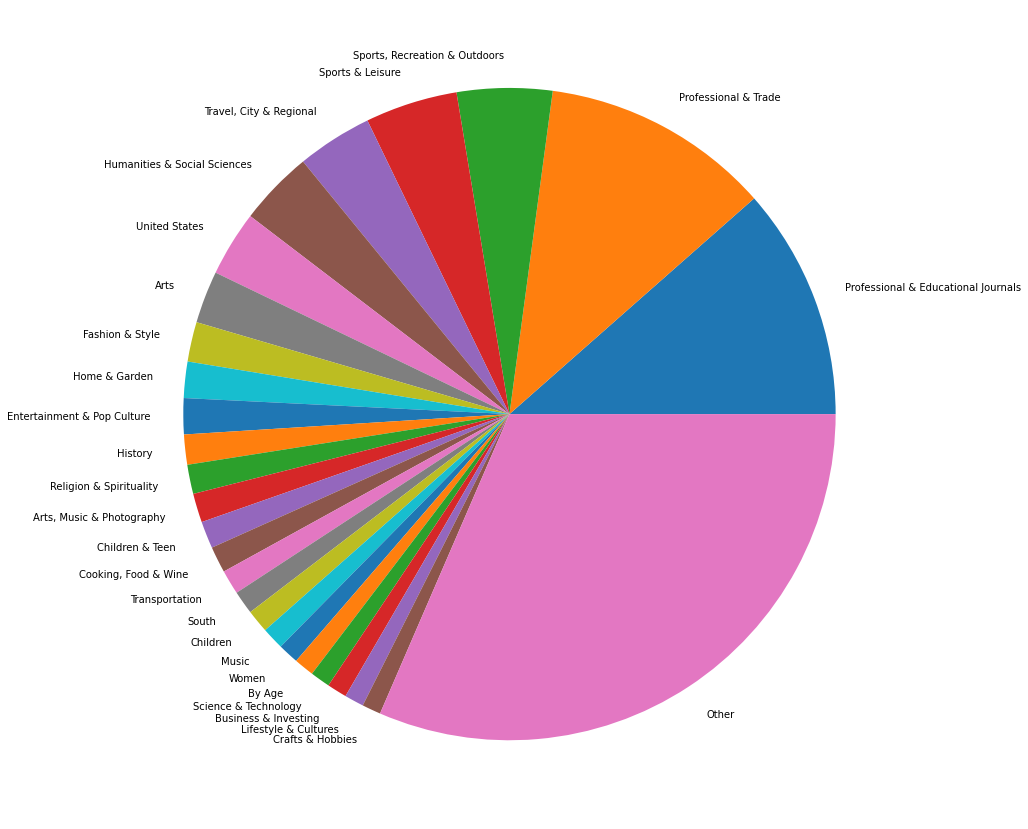

In [5]:
import matplotlib.pyplot as plt

plt.pie(df_CatCount.amount, labels = df_CatCount.category)
fig = plt.gcf()
fig.set_size_inches(15,15)
#fig.show()

### User Overall Voting Range 

In [6]:
vote_counts = df_magsubs.groupby("overall")['overall'].count()
vote_counts

overall
1     6098
2     2436
3     2332
4     3041
5    10192
Name: overall, dtype: int64

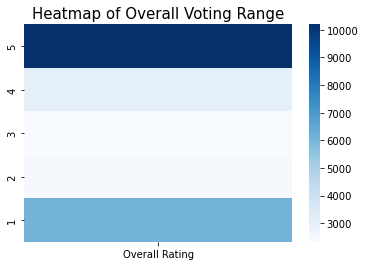

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

vote_counts_2 = [ 
    {'Overall Rating':6098},
    {'Overall Rating':2436},
     {'Overall Rating':2332},
     { 'Overall Rating':3041},
    { 'Overall Rating':10192}, 
    ]
vote_counts = pd.DataFrame(vote_counts_2)

hm = sns.heatmap(vote_counts, yticklabels=[1,2,3,4,5], cmap="Blues")
hm.invert_yaxis()

plt.title('Heatmap of Overall Voting Range', fontsize = 15)
plt.show()

Users voted mostly 5 stars, followed by 1 star voters. 4 star votes are third most common. 3 and 2 star votes are least frequent and are very close in amount. 

### Verified vs Unverified Users

Unverified: reviewer did not purchase product on amazon or purchased the product at a discounted price.

We wanted to see if there was a correlation between verified vs. unverified users.

Would a discounted price entice a user to give a higher review?

In [8]:
import numpy as np
print("Average ratings of reviews between Verified vs Unverified Users")
df_rev = df_magsubs.pivot_table(values=["overall"], index=["asin"], columns = ["verified"], aggfunc = np.mean)

df_rev.dropna(inplace=True)

df_rev

Average ratings of reviews between Verified vs Unverified Users


overall          
verified       False      True
asin                          
B00005N7NQ  3.619048  3.791667
B00005N7O6  4.500000  4.600000
B00005N7OA  3.142857  5.000000
B00005N7OC  2.333333  2.000000
B00005N7OD  3.321429  2.900000
...              ...       ...
B01DT6OMB4  1.000000  5.000000
B01DT6PL46  1.000000  1.666667
B01DWVLMJG  5.000000  5.000000
B01F2MKW0I  3.500000  4.652174
B01HI8V1I6  4.500000  5.000000

[980 rows x 2 columns]

In [9]:
df = df_magsubs.groupby("verified")["overall"].mean()
df

verified
False    3.241238
True     3.513430
Name: overall, dtype: float64

<AxesSubplot:xlabel='verified'>

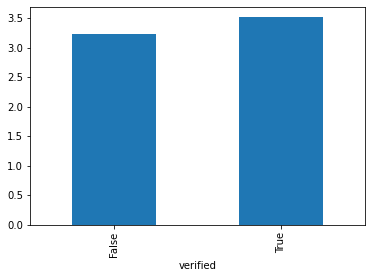

In [10]:
df.plot.bar()

Surprisingly, the mean of the unverified ratings was lower. We can assume that verification has no impact on the rating of a product.

### Bag of Words Reviews

In [11]:
import pandas as pd
pd.options.mode.chained_assignment = None
import string
df = pd.read_json("Magazine_Subscriptions.json", lines=True)
df.to_csv()
df["asin"] = df["asin"].apply(str)
df['reviewText'] = df['reviewText'].str.lower()
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]','',regex=True)
df['reviewText'] = df['reviewText'].fillna("NoReview")
df_reviews = df[["reviewerID","asin","reviewText"]]
df_reviews.head()

,reviewerID,asin,reviewText
0,AH2IFH762VY5U,B00005N7P0,for computer enthusiast maxpc is a welcome sig...
1,AOSFI0JEYU4XM,B00005N7P0,thank god this is not a ziff davis publication...
2,A3JPFWKS83R49V,B00005N7OJ,antiques magazine is a publication made for an...
3,A19FKU6JZQ2ECJ,B00005N7OJ,this beautiful magazine is in itself a work of...
4,A25MDGOMZ2GALN,B00005N7P0,a great read every issue


In [12]:
reviewCounts = pd.Series([y for x in df_reviews.values.flatten() for y in x.split()]).value_counts()
reviewCounts.head(50)

the             174797
i               121482
and             115459
to              108471
a                93202
of               75283
it               70257
magazine         67653
is               60526
for              59388
this             55926
in               45258
that             39275
my               39237
on               31389
have             29855
you              28464
not              27018
are              26845
but              25317
with             25273
great            22966
as               22173
was              20719
articles         17815
they             17512
be               17410
love             16717
like             16553
subscription     16260
read             16061
its              15940
so               15919
good             15408
all              14830
issue            14541
about            14455
or               14078
one              14023
has              13600
if               13288
me               12726
more             12559
at         

The words most used in reviews were common words such as "the", "I", "and", "to". The words "magazine" and "subscription" appeared quite often due to the subject of our study. It also influenced words such as "read","issue", "articles" since magazines are an issue of articles that are being read. Based off the top words alone, it seems that most people have positive reviews on the magazines since there aren't many negative connotated words while the positive ones being somewhat common ("good", "great").

In [13]:
input = "This magazine is great, and the stories are very interesting."
input = input.lower()
input = input.translate(str.maketrans('', '', string.punctuation))
input

'this magazine is great and the stories are very interesting'

This will be the input review that we will be testing for the highest cosine similarity.

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
df_Sim = df_reviews
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cindy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
input_set = set(word_tokenize(input))
df_Sim['tokenReview'] = df_Sim['reviewText'].apply(word_tokenize).apply(set) 
df_Sim.head()

,reviewerID,asin,reviewText,tokenReview
0,AH2IFH762VY5U,B00005N7P0,for computer enthusiast maxpc is a welcome sig...,"{mailbox, subscription, cant, called, knowledg..."
1,AOSFI0JEYU4XM,B00005N7P0,thank god this is not a ziff davis publication...,"{will, davis, this, to, no, product, technical..."
2,A3JPFWKS83R49V,B00005N7OJ,antiques magazine is a publication made for an...,"{will, these, certainly, history, are, similar..."
3,A19FKU6JZQ2ECJ,B00005N7OJ,this beautiful magazine is in itself a work of...,"{this, ago, in, magazine, many, quality, that,..."
4,A25MDGOMZ2GALN,B00005N7P0,a great read every issue,"{great, every, issue, a, read}"


In [16]:
df_Sim['Similarity'] = 0
for index, row in df_Sim.iterrows():
    currVector = input_set.union(row['tokenReview'])
    l1 =[];l2 =[]
    for w in currVector:
        if w in input_set: l1.append(1)
        else: l1.append(0)
        if w in row['tokenReview']: l2.append(1)
        else: l2.append(0)
    c = 0
    for i in range(len(currVector)):
        c+= l1[i]*l2[i]
    if sum(l2) == 0:
        df_Sim.loc[index, 'Similarity'] = 0
    else:
        df_Sim.loc[index, 'Similarity'] = c / float((sum(l1)*sum(l2))**0.5)
df_Sim.head()

,reviewerID,asin,reviewText,tokenReview,Similarity
0,AH2IFH762VY5U,B00005N7P0,for computer enthusiast maxpc is a welcome sig...,"{mailbox, subscription, cant, called, knowledg...",0.146176
1,AOSFI0JEYU4XM,B00005N7P0,thank god this is not a ziff davis publication...,"{will, davis, this, to, no, product, technical...",0.144673
2,A3JPFWKS83R49V,B00005N7OJ,antiques magazine is a publication made for an...,"{will, these, certainly, history, are, similar...",0.178885
3,A19FKU6JZQ2ECJ,B00005N7OJ,this beautiful magazine is in itself a work of...,"{this, ago, in, magazine, many, quality, that,...",0.300000
4,A25MDGOMZ2GALN,B00005N7P0,a great read every issue,"{great, every, issue, a, read}",0.141421


In [17]:
df_Sim.sort_values(by=['Similarity'], ascending=False)

,reviewerID,asin,reviewText,tokenReview,Similarity
73095,A186HTO2DI1809,B00YQH9856,this magazine is very interesting and informative,"{this, magazine, interesting, is, informative,...",0.717137
15372,A1IBJDINIBX9EY,B00005N7QG,love this magazine and the price is great,"{love, this, the, magazine, great, price, is, ...",0.670820
37269,A3TWWC2B55AGVR,B00007B10Y,wonderful magazine and very great stories,"{wonderful, magazine, great, very, stories, and}",0.645497
81565,A3KVMN9OTVVUJR,B000BYD9V2,great magazine very interesting and informative,"{magazine, interesting, great, informative, ve...",0.645497
67029,A3RO06TXVLAJU5,B005DNA3LU,the magazine is colorful and interesting,"{the, magazine, interesting, is, colorful, and}",0.645497
...,...,...,...,...,...
80244,A23QGG90CNKFRP,B00008WETF,as advertised,"{advertised, as}",0.000000
62525,AQTAZTY0T3LIF,B001C4Q06G,i have yet to receive an issue,"{have, to, receive, yet, issue, an, i}",0.000000
62526,A2E0P8AUHQOSGR,B001C4Q06G,thanks,{thanks},0.000000
35809,A1L5PVBLJJME7V,B00007B10Y,always enjoy,"{enjoy, always}",0.000000


Based off the cosine similarity analysis on our bag of words model, the top result with a similarity of 0.717 shows the reviewerID and the text they wrote, which is in fact similar to our input review.

### Correlation between length of review and how many votes it receives

<AxesSubplot:xlabel='vote', ylabel='reviewlen'>

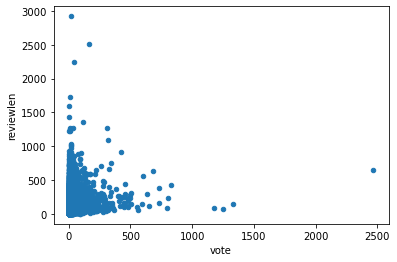

In [18]:
import numpy as np

#create column for the word count of each review
df_magsubs["reviewlen"] = df_magsubs["reviewText"].str.split().str.len()

df_reviewlen = df_magsubs.pivot_table(values=["reviewlen"],index=['vote'],aggfunc=np.mean)

df_reviewlen.groupby('vote').mean()["reviewlen"]

df_magsubs.plot.scatter(x='vote',y='reviewlen')

From this data distribution, we can see that there is a strong correlation between the length of the review by number of words and the number of votes that it receives for lower values. However, as the length of reviews increases by a large amount, the number of votes received decreases greatly on average. Opposingly, reviews between 0-700 words seem to receive the greatest amount of votes and exposure.

### Average Number of Votes When Images Are or Are Not Included

<AxesSubplot:>

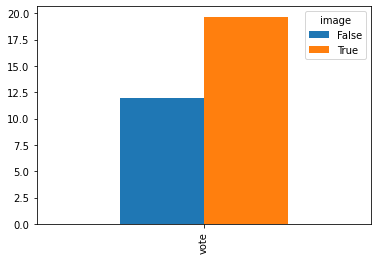

In [19]:
df_image = df_magsubs.pivot_table(values=["vote"],columns=["image"])

df_image.plot.bar()

In this bar graph, we can see that on average, the number of votes received for reviews that included images is around 60% higher than reviews that opted to not include images. The inclusion of images seems to give more exposure to those respective reviews and thus earned more votes.

# The Main Part: 
## Collaborative Filtering

Here we use collaborative filtering to build a recommender system based on reviews given by customers. Given a set of ratings that determine what a user things about certain magazines, our recommender system recommends certain other magazines the user has not read based on how similar their existing preferences are to other users who have data in our system on the assumption that similar people like similar things. The existence of the dataset online eliminates the cold start and first rater problems that come with collaborative filtering.

In [20]:
dfNumReviewers = df_magsubs.groupby('asin').size().to_frame('amount')
dfNumReviewers.reset_index(inplace=True)
dfNumReviewers.sort_values(by=['amount'], ascending=False)

,asin,amount
893,B00077B7M6,481
125,B00005NIOH,345
215,B000063XJL,291
679,B00007BK3L,248
1122,B0012C1O8C,240
...,...,...
1320,B009CWB3ZS,1
815,B0000CCYDL,1
384,B00006KKAI,1
382,B00006KJP6,1


In [41]:
from scipy.sparse import csr_matrix
userInput = [ 
    {'asin':'B00005N7P0', 'overall':5},
    {'asin':'B00005N7OJ', 'overall':3},
     {'asin':'B000063XJL', 'overall':2},
     {'asin':'B00005N7PS', 'overall':3},
    {'asin':'B00005N7NQ', 'overall': 5},
    {'asin':'B00005N7QS', 'overall': 1},
    {'asin':'B00005N7OU', 'overall': 4},
    {'asin':'B00005N7RD', 'overall': 2},
    {'asin':'B00D8GWHYK', 'overall': 3},
    ]
inputMag = pd.DataFrame(userInput)
inputMag

,asin,overall
0,B00005N7P0,5
1,B00005N7OJ,3
2,B000063XJL,2
3,B00005N7PS,3
4,B00005N7NQ,5
5,B00005N7QS,1
6,B00005N7OU,4
7,B00005N7RD,2
8,B00D8GWHYK,3


In [42]:
userSubset = df_magsubs[df_magsubs['asin'].isin(inputMag['asin'].tolist())]
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(userSubset)
userSubset

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,5,9,False,"11 8, 2001",AH2IFH762VY5U,B00005N7P0,ted sedlmayr,"for computer enthusiast, MaxPC is a welcome si...","AVID READER SINCE ""boot"" WAS THE NAME",1005177600,NaN,NaN
1,5,9,False,"10 31, 2001",AOSFI0JEYU4XM,B00005N7P0,Amazon Customer,Thank god this is not a Ziff Davis publication...,The straight scoop,1004486400,NaN,NaN
2,3,14,False,"03 24, 2007",A3JPFWKS83R49V,B00005N7OJ,Bryan Carey,Antiques Magazine is a publication made for an...,"Antiques Magazine is Good, but not for Everyone",1174694400,{'Format:': ' Print Magazine'},NaN
3,5,13,False,"11 10, 2006",A19FKU6JZQ2ECJ,B00005N7OJ,Patricia L. Porada,This beautiful magazine is in itself a work of...,THE DISCERNING READER,1163116800,{'Format:': ' Print Magazine'},NaN
4,5,NaN,True,"07 14, 2014",A25MDGOMZ2GALN,B00005N7P0,Alvey,A great read every issue.,Five Stars,1405296000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
85584,2,NaN,True,"07 12, 2015",A1K5L1ZQQLGON5,B00D8GWHYK,Saeed,not that much of iteresting contents.,Two Stars,1436659200,{'Format:': ' Print Magazine'},NaN
85585,4,NaN,True,"04 23, 2015",A2YNC7CHSAMRUE,B00D8GWHYK,David G.,Now with more technology.,Four Stars,1429747200,{'Format:': ' Print Magazine'},NaN
85586,1,NaN,True,"04 3, 2015",A18EQZ8EIR31YU,B00D8GWHYK,Adventure and Coffee,careful with this subscription. They renewed m...,"great magazine, but not worth the spam",1428019200,{'Format:': ' Print Magazine'},NaN
85587,3,NaN,True,"03 31, 2015",A1GBAK1PWLAWRG,B00D8GWHYK,Susan L,Articles you wouldn't expect to see in a magaz...,Three Stars,1427760000,{'Format:': ' Print Magazine'},NaN


In [43]:
userSubGroup = userSubset.groupby(['reviewerID'])
#userSubset.sort_values(by=['reviewerID'], ascending=False)

In [44]:
userSubGroup = sorted(userSubGroup,  key=lambda x: len(x[1]), reverse=True)
#userSubGroup
len(userSubGroup)# number of reviews of the 4 user-picked magazines, sorted in groups by reviewer descending by how many of the magazines 
                    #users reviewed among the 4 (highest rn is 2 at the same time)

1813

In [45]:
import scipy.stats as sp
pearsonCorrelation= {}

for reviewerID, group in userSubGroup:
    group = group.sort_values(by='asin')
    inputMag = inputMag.sort_values(by='asin')

    nRatings = len(group)
    
    temp_df = inputMag[inputMag['asin'].isin(group['asin'].tolist())]
    
    tempRateList = temp_df['overall'].tolist()
    tempGroupList = group['overall'].tolist()
    
    #tempRateList
    #tempGroupList
    #sp.stats.pearsonr(tempRateList,tempGroupList)[0] #doesn't work if corresponding reviewer only has watched 1 of the shows on the list
    #print(tempRateList, pow(sum(tempRateList),2))
    Sxx = sum([i**2 for i in tempRateList]) - pow(sum(tempRateList),2)/float(nRatings)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(nRatings)
    Sxy = sum( i*j for i, j in zip(tempRateList, tempGroupList)) - sum(tempRateList)*sum(tempGroupList)/float(nRatings)
    if Sxx != 0 and Syy != 0:
        pearsonCorrelation[reviewerID] = Sxy/np.sqrt(Sxx*Syy)
    else:
        pearsonCorrelation[reviewerID] = 0

In [46]:
pearsonCorrelation.items()

dict_items([('A3JPFWKS83R49V', 0.9669875568304565), ('A26PEGXTHPZQEE', 0.18898223650461307), ('A185HS1WWV8DGP', 0), ('A1APD0GQAENV32', 1.0), ('A1EMDSTJDUE6B0', -1.0), ('A1N3CH42SZWEP', 0), ('A1RPTVW5VEOSI', 1.0), ('A1TN9J7R4C1OMJ', 0), ('A2067RFMEGJGG5', -1.0), ('A34PAZQ73SL163', 1.0), ('A3BO1VM9CSCWW1', 0), ('A3DANZMETXAT1G', 0), ('A3NLVHGP3D7ADP', 0), ('A3SZGJOKXTL4D2', 0), ('A5RHZE7B8SV5Q', -1.0), ('A8Q5H2TT4822H', 0), ('AEMZRE6QYVQBS', 1.0), ('A1047EDJ84IMAS', 0), ('A104A78LSH9RTN', 0), ('A1088JT1L28OP5', 0), ('A109CREBBPLP9L', 0), ('A10AZ2K919UGQ', 0), ('A10CI4Z9LGWA55', 0), ('A10DGW0YSXAB70', 0), ('A10EYTJF60COV2', 0), ('A10J9DQ7JAH3P0', 0), ('A10L44QHAT8A7P', 0), ('A10L46FJZJLZ5E', 0), ('A10O0I4H323CND', 0), ('A10P5ZZYRHWE61', 0), ('A10X0IABJDBYNG', 0), ('A10YGG9458X5GQ', 0), ('A10YJWC12N3FXT', 0), ('A10YMCG6O18Y9S', 0), ('A111OZBYXLLB6C', 0), ('A112OID07NKUTM', 0), ('A114RDBJWMMY5C', 0), ('A11CNXOXKR6H3K', 0), ('A11HAMH0WY92IU', 0), ('A11MGBWD6MM0OW', 0), ('A11N67JH4FB6HL', 0),

In [47]:
pearsonDF = pd.DataFrame.from_dict(pearsonCorrelation, orient='index')
pearsonDF.head()

,0
A3JPFWKS83R49V,0.966988
A26PEGXTHPZQEE,0.188982
A185HS1WWV8DGP,0.000000
A1APD0GQAENV32,1.000000
A1EMDSTJDUE6B0,-1.000000


In [48]:
pearsonDF.columns = ['similarityIndex']
pearsonDF['reviewerID'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))
pearsonDF.head()

,similarityIndex,reviewerID
0,0.966988,A3JPFWKS83R49V
1,0.188982,A26PEGXTHPZQEE
2,0.000000,A185HS1WWV8DGP
3,1.000000,A1APD0GQAENV32
4,-1.000000,A1EMDSTJDUE6B0


In [49]:
topUsers=pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:50]
topUsers.head()

,similarityIndex,reviewerID
16,1.000000,AEMZRE6QYVQBS
6,1.000000,A1RPTVW5VEOSI
9,1.000000,A34PAZQ73SL163
3,1.000000,A1APD0GQAENV32
0,0.966988,A3JPFWKS83R49V


Similarity index is not very varied. This does not seem like a good approach for this data.

## Content-Based Filtering

After we realized the collaboratie filtering approach would not work, we decided to use content-based filtering instead. It would make more sense to use content-based filtering in this scenario because our magazines are more item-based rather than user-based.

In [50]:
import pandas as pd
import numpy as np
# ALL RATINGS FOR ALL MAGAZINES 
df_magsubs = pd.read_json('Magazine_Subscriptions.json', lines=True)
df_ratings = df_magsubs[["overall", "reviewerID", "asin"]]
df_ratings

,overall,reviewerID,asin
0,5,AH2IFH762VY5U,B00005N7P0
1,5,AOSFI0JEYU4XM,B00005N7P0
2,3,A3JPFWKS83R49V,B00005N7OJ
3,5,A19FKU6JZQ2ECJ,B00005N7OJ
4,5,A25MDGOMZ2GALN,B00005N7P0
...,...,...,...
89684,5,AB5HCI50SF1TK,B01HI8V1C2
89685,1,A2X11NZMPI7M0T,B01HI8V1C2
89686,5,A3EGFFBRQVO7L7,B01HI8V1C2
89687,5,A3H23AVKFN62ZT,B01HIZSSQM


In [51]:
# ALL MAGAZINES AND THEIR GENRE 
df_metamagsubs = pd.read_json('meta_Magazine_Subscriptions.json', lines=True)
df_metamagsubs = df_metamagsubs[["asin", "category"]]
# indexNames = df_metamagsubs[df_metamagsubs['category'] == '[]' ].index
# df_metamagsubs = df_metamagsubs.drop(indexNames , inplace=True)

df_metamagsubs

,asin,category
0,B00005N7NQ,"[Magazine Subscriptions, Professional & Educat..."
1,B00005N7OC,"[Magazine Subscriptions, Arts, Music &amp; Pho..."
2,B00005N7OD,"[Magazine Subscriptions, Fashion &amp; Style, ..."
3,B00005N7O9,"[Magazine Subscriptions, Sports, Recreation & ..."
4,B00005N7O6,"[Magazine Subscriptions, Professional & Educat..."
...,...,...
3380,B01HI8V19K,[]
3381,B01HI8V1I6,"[Magazine Subscriptions, Sports, Recreation & ..."
3382,B01HI8V0ZK,"[Magazine Subscriptions, Fashion & Style]"
3383,B01HI8V1C2,[]


In [52]:
df_metamagsubs = df_metamagsubs.loc[df_metamagsubs.astype(str).drop_duplicates().index]
df_metamagsubs

,asin,category
0,B00005N7NQ,"[Magazine Subscriptions, Professional & Educat..."
1,B00005N7OC,"[Magazine Subscriptions, Arts, Music &amp; Pho..."
2,B00005N7OD,"[Magazine Subscriptions, Fashion &amp; Style, ..."
3,B00005N7O9,"[Magazine Subscriptions, Sports, Recreation & ..."
4,B00005N7O6,"[Magazine Subscriptions, Professional & Educat..."
...,...,...
3380,B01HI8V19K,[]
3381,B01HI8V1I6,"[Magazine Subscriptions, Sports, Recreation & ..."
3382,B01HI8V0ZK,"[Magazine Subscriptions, Fashion & Style]"
3383,B01HI8V1C2,[]


# One-Hot Encoding

In [53]:
# BREAKING UP ALL THE GENRES AND COUNTING THEM WITH 1 OR 0
magGenres = df_metamagsubs.copy()

#For every row in the dataframe, iterate through the list of genres and place a 1 into the corresponding column
for index, row in df_metamagsubs.iterrows():
    for genre in row['category']:
        magGenres.at[index, genre] = 1
        
#Filling in the NaN values with 0 to show that a magazine doesn't have that column's genre
magGenres = magGenres.fillna(0)
magGenres.drop(['Magazine Subscriptions'], axis = 1, inplace=True)
magGenres.drop(['category'], axis = 1, inplace=True)
magGenres.head()

C:\Users\cindy\anaconda3\lib\site-packages\pandas\core\indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


,asin,Professional & Educational Journals,Professional & Trade,Humanities & Social Sciences,Economics & Economic Theory,"Arts, Music &amp; Photography",Music,Fashion &amp; Style,Women,"Sports, Recreation & Outdoors",...,Racket Sports,Spanish-Language,Interior Design,Country Life,Alternative & Holistic,Girls,Mathematics,Animals,Agricultural Sciences,Soccer
0,B00005N7NQ,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,B00005N7OC,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,B00005N7OD,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,B00005N7O9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,B00005N7O6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
# USER WE ARE RECOMMENDING TO 
from scipy.sparse import csr_matrix
userInput = [ 
    {'asin':'B00005N7OP', 'overall':1},
    {'asin':'B00005N7OC', 'overall':1},
    {'asin':'B00005N7UG', 'overall':5},
    {'asin':'B00005N7Q5', 'overall':5},
    {'asin':'B00005N7S2', 'overall':5},
    {'asin':'B00005N7O9', 'overall': 5},
    {'asin':'B00005N7RD', 'overall': 5}
    ]
inputMags = pd.DataFrame(userInput)
inputMags

,asin,overall
0,B00005N7OP,1
1,B00005N7OC,1
2,B00005N7UG,5
3,B00005N7Q5,5
4,B00005N7S2,5
5,B00005N7O9,5
6,B00005N7RD,5


In [68]:
userMags = magGenres[magGenres['asin'].isin(inputMags['asin'].tolist())]
userMags

,asin,Professional & Educational Journals,Professional & Trade,Humanities & Social Sciences,Economics & Economic Theory,"Arts, Music &amp; Photography",Music,Fashion &amp; Style,Women,"Sports, Recreation & Outdoors",...,Racket Sports,Spanish-Language,Interior Design,Country Life,Alternative & Holistic,Girls,Mathematics,Animals,Agricultural Sciences,Soccer
1,B00005N7OC,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,B00005N7O9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,B00005N7OP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,B00005N7Q5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,B00005N7S2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,B00005N7RD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,B00005N7UG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
userMags = userMags.reset_index(drop=True)

#Dropping unnecessary issues due to save memory and to avoid issues
userGenreTable = userMags.drop(['asin'], axis = 1)
userGenreTable

,Professional & Educational Journals,Professional & Trade,Humanities & Social Sciences,Economics & Economic Theory,"Arts, Music &amp; Photography",Music,Fashion &amp; Style,Women,"Sports, Recreation & Outdoors",Sports & Leisure,...,Racket Sports,Spanish-Language,Interior Design,Country Life,Alternative & Holistic,Girls,Mathematics,Animals,Agricultural Sciences,Soccer
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
inputMags['overall']

0    1
1    1
2    5
3    5
4    5
5    5
6    5
Name: overall, dtype: int64

In [71]:
userProfile = userGenreTable.transpose().dot(inputMags['overall'])

#The user profile
userProfile

Professional & Educational Journals    0.0
Professional & Trade                   0.0
Humanities & Social Sciences           0.0
Economics & Economic Theory            0.0
Arts, Music &amp; Photography          1.0
                                      ... 
Girls                                  0.0
Mathematics                            0.0
Animals                                0.0
Agricultural Sciences                  0.0
Soccer                                 0.0
Length: 226, dtype: float64

In [59]:
genreTable = magGenres.set_index(magGenres['asin'])
for index, row in userMags.iterrows():
    genreTable = genreTable[genreTable.asin != row.asin]
genreTable.drop(['asin'], axis = 1, inplace=True)
genreTable

,Professional & Educational Journals,Professional & Trade,Humanities & Social Sciences,Economics & Economic Theory,"Arts, Music &amp; Photography",Music,Fashion &amp; Style,Women,"Sports, Recreation & Outdoors",Sports & Leisure,...,Racket Sports,Spanish-Language,Interior Design,Country Life,Alternative & Holistic,Girls,Mathematics,Animals,Agricultural Sciences,Soccer
asin,,,,,,,,,,,,,,,,,,,,,
B00005N7OC,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00005N7OD,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00005N7O9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00005N7O6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00005N7QG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B01HI8V19K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B01HI8V1I6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B01HI8V0ZK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
genreTable.shape

(2311, 226)

In [64]:
recommendationTable_df = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum())
recommendationTable_df.head()

asin
B00005N7OC    0.013699
B00005N7OD    0.000000
B00005N7O9    0.000000
B00005N7O6    0.136986
B00005N7QG    0.000000
dtype: float64

In [65]:
recommendationTable_df = recommendationTable_df.sort_values(ascending=False)

#Just a peek at the values
recommendationTable_df.head()

asin
B00007KXPH    0.273973
B00008MNA9    0.273973
B00006K25E    0.273973
B00005N7R5    0.273973
B00006KBGM    0.273973
dtype: float64

In [66]:
df_metamagsubs.loc[df_metamagsubs['asin'].isin(recommendationTable_df.head().keys())]

,asin,category
85,B00005N7R5,"[Magazine Subscriptions, Professional & Educat..."
334,B00006KBGM,"[Magazine Subscriptions, Professional & Educat..."
341,B00006K25E,"[Magazine Subscriptions, Professional & Educat..."
856,B00007KXPH,"[Magazine Subscriptions, Professional & Educat..."
923,B00008MNA9,"[Magazine Subscriptions, Professional & Educat..."
